# Requirements

In [1]:
!apt-get install -y openjdk-11-jdk-headless
!mkdir -p tablesaw_lib
!wget -P tablesaw_lib https://repo1.maven.org/maven2/tech/tablesaw/tablesaw-core/0.43.1/tablesaw-core-0.43.1.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/tech/tablesaw/tablesaw-aggregate/0.43.1/tablesaw-aggregate-0.43.1.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/tech/tablesaw/tablesaw-io-csv/0.43.1/tablesaw-io-csv-0.43.1.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/org/apache/commons/commons-csv/1.8/commons-csv-1.8.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/it/unimi/dsi/fastutil/8.5.12/fastutil-8.5.12.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/io/github/classgraph/classgraph/4.8.90/classgraph-4.8.90.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/com/univocity/univocity-parsers/2.9.1/univocity-parsers-2.9.1.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.30/slf4j-api-1.7.30.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/org/slf4j/slf4j-simple/1.7.30/slf4j-simple-1.7.30.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/com/google/guava/guava/31.1-jre/guava-31.1-jre.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/com/ibm/icu/icu4j/67.1/icu4j-67.1.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/org/apache/commons/commons-math3/3.6.1/commons-math3-3.6.1.jar
!wget -P tablesaw_lib https://repo1.maven.org/maven2/org/roaringbitmap/RoaringBitmap/0.9.39/RoaringBitmap-0.9.39.jar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.27+6~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
--2025-06-16 19:33:31--  https://repo1.maven.org/maven2/tech/tablesaw/tablesaw-core/0.43.1/tablesaw-core-0.43.1.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 634968 (620K) [application/java-archive]
Saving to: ‘tablesaw_lib/tablesaw-core-0.43.1.jar’

tablesaw-core-0.43. 100%[===================>] 620.09K  --.-KB/s    in 0.03s   

2025-06-16 19:33:31 (17.7 MB/s) - ‘tablesaw_lib/tablesaw-core-0.43.1.jar’ saved [634968/634968]

--2025-06-16 19:33:31--  https://repo1.maven.org/maven2/tech/tablesaw/tablesaw-aggregate/0.43.1/tablesaw-aggregate-0.43.1.ja

In [2]:
code = """
import tech.tablesaw.api.*;
import tech.tablesaw.aggregate.AggregateFunctions;

import java.io.*;
import java.util.*;
import java.time.Instant;

public class TablesawBenchmark {

    static class BenchmarkResult {
        long timeMs;
        long memoryMb;

        BenchmarkResult(long timeMs, long memoryMb) {
            this.timeMs = timeMs;
            this.memoryMb = memoryMb;
        }
    }

    private static long getMemoryUsage() {
        Runtime runtime = Runtime.getRuntime();
        return (runtime.totalMemory() - runtime.freeMemory()) / (1024 * 1024);
    }

    private static void generateTestData(int nRows, String filename) throws IOException {
        Random rand = new Random(42);
        try (PrintWriter writer = new PrintWriter(new FileWriter(filename))) {
            // Write header
            writer.println("id,category,value1,value2");

            // Write data
            for (int i = 0; i < nRows; i++) {
                String category = "cat_" + rand.nextInt(10);
                double value1 = rand.nextGaussian() * 20 + 100;
                double value2 = rand.nextDouble() * 1000;
                writer.printf("%d,%s,%.2f,%.2f%n", i, category, value1, value2);
            }
        }
    }

    private static Map<String, BenchmarkResult> benchmarkTablesaw(String filename) throws IOException {
        Map<String, BenchmarkResult> results = new HashMap<>();
        long initialMemory = getMemoryUsage();

        // Read operation
        long startTime = System.currentTimeMillis();
        Table table = Table.read().csv(filename);
        results.put("read", new BenchmarkResult(
                System.currentTimeMillis() - startTime,
                getMemoryUsage() - initialMemory
        ));

        // Sort operation
        startTime = System.currentTimeMillis();
        Table sortedTable = table.sortOn("value1");
        results.put("sort", new BenchmarkResult(
                System.currentTimeMillis() - startTime,
                getMemoryUsage() - initialMemory
        ));

        // Filter operation
        startTime = System.currentTimeMillis();
        Table filteredTable = table.where(table.doubleColumn("value1").isGreaterThan(110));
        results.put("filter", new BenchmarkResult(
                System.currentTimeMillis() - startTime,
                getMemoryUsage() - initialMemory
        ));

        // GroupBy operation
        startTime = System.currentTimeMillis();
        Table groupedTable = table.summarize("value2", AggregateFunctions.mean).by("category");
        results.put("groupby", new BenchmarkResult(
                System.currentTimeMillis() - startTime,
                getMemoryUsage() - initialMemory
        ));

        return results;
    }

    public static void main(String[] args) throws IOException {
        int[] sizes = {10000, 100000, 1000000};

        try (PrintWriter writer = new PrintWriter(new FileWriter("tablesaw_results.csv"))) {
            writer.println("size,operation,time_ms,memory_mb");

            for (int size : sizes) {
                String filename = "test_data_" + size + ".csv";
                generateTestData(size, filename);
                Map<String, BenchmarkResult> results = benchmarkTablesaw(filename);

                for (Map.Entry<String, BenchmarkResult> entry : results.entrySet()) {
                    String line = String.format("%d,%s,%d,%d",
                            size, entry.getKey(), entry.getValue().timeMs, entry.getValue().memoryMb);
                    writer.println(line);
                    System.out.printf("Size: %d, Operation: %s, Time: %dms, Memory: %dMB%n",
                            size, entry.getKey(), entry.getValue().timeMs, entry.getValue().memoryMb);
                }
            }
        }
    }
}

"""
with open("TablesawBenchmark.java", "w") as f:
    f.write(code)


## It was with CPU

In [3]:
!javac -cp ".:tablesaw_lib/*" TablesawBenchmark.java

In [4]:
!java -cp ".:tablesaw_lib/*" TablesawBenchmark

Size: 10000, Operation: filter, Time: 28ms, Memory: 73MB
Size: 10000, Operation: read, Time: 1091ms, Memory: 71MB
Size: 10000, Operation: sort, Time: 33ms, Memory: 72MB
Size: 10000, Operation: groupby, Time: 87ms, Memory: 81MB
Size: 100000, Operation: filter, Time: 45ms, Memory: 10MB
Size: 100000, Operation: read, Time: 298ms, Memory: -3MB
Size: 100000, Operation: sort, Time: 108ms, Memory: 5MB
Size: 100000, Operation: groupby, Time: 131ms, Memory: 56MB
Size: 1000000, Operation: filter, Time: 204ms, Memory: 219MB
Size: 1000000, Operation: read, Time: 1006ms, Memory: 73MB
Size: 1000000, Operation: sort, Time: 716ms, Memory: 163MB
Size: 1000000, Operation: groupby, Time: 634ms, Memory: 33MB


## It is with GPU

In [3]:
!javac -cp ".:tablesaw_lib/*" TablesawBenchmark.java

In [4]:
!java -cp ".:tablesaw_lib/*" TablesawBenchmark

Size: 10000, Operation: filter, Time: 45ms, Memory: 74MB
Size: 10000, Operation: read, Time: 1165ms, Memory: 72MB
Size: 10000, Operation: sort, Time: 37ms, Memory: 73MB
Size: 10000, Operation: groupby, Time: 108ms, Memory: 82MB
Size: 100000, Operation: filter, Time: 64ms, Memory: 6MB
Size: 100000, Operation: read, Time: 367ms, Memory: -7MB
Size: 100000, Operation: sort, Time: 158ms, Memory: 1MB
Size: 100000, Operation: groupby, Time: 134ms, Memory: 53MB
Size: 1000000, Operation: filter, Time: 244ms, Memory: 184MB
Size: 1000000, Operation: read, Time: 1392ms, Memory: 38MB
Size: 1000000, Operation: sort, Time: 664ms, Memory: 127MB
Size: 1000000, Operation: groupby, Time: 781ms, Memory: 271MB


# Visualization

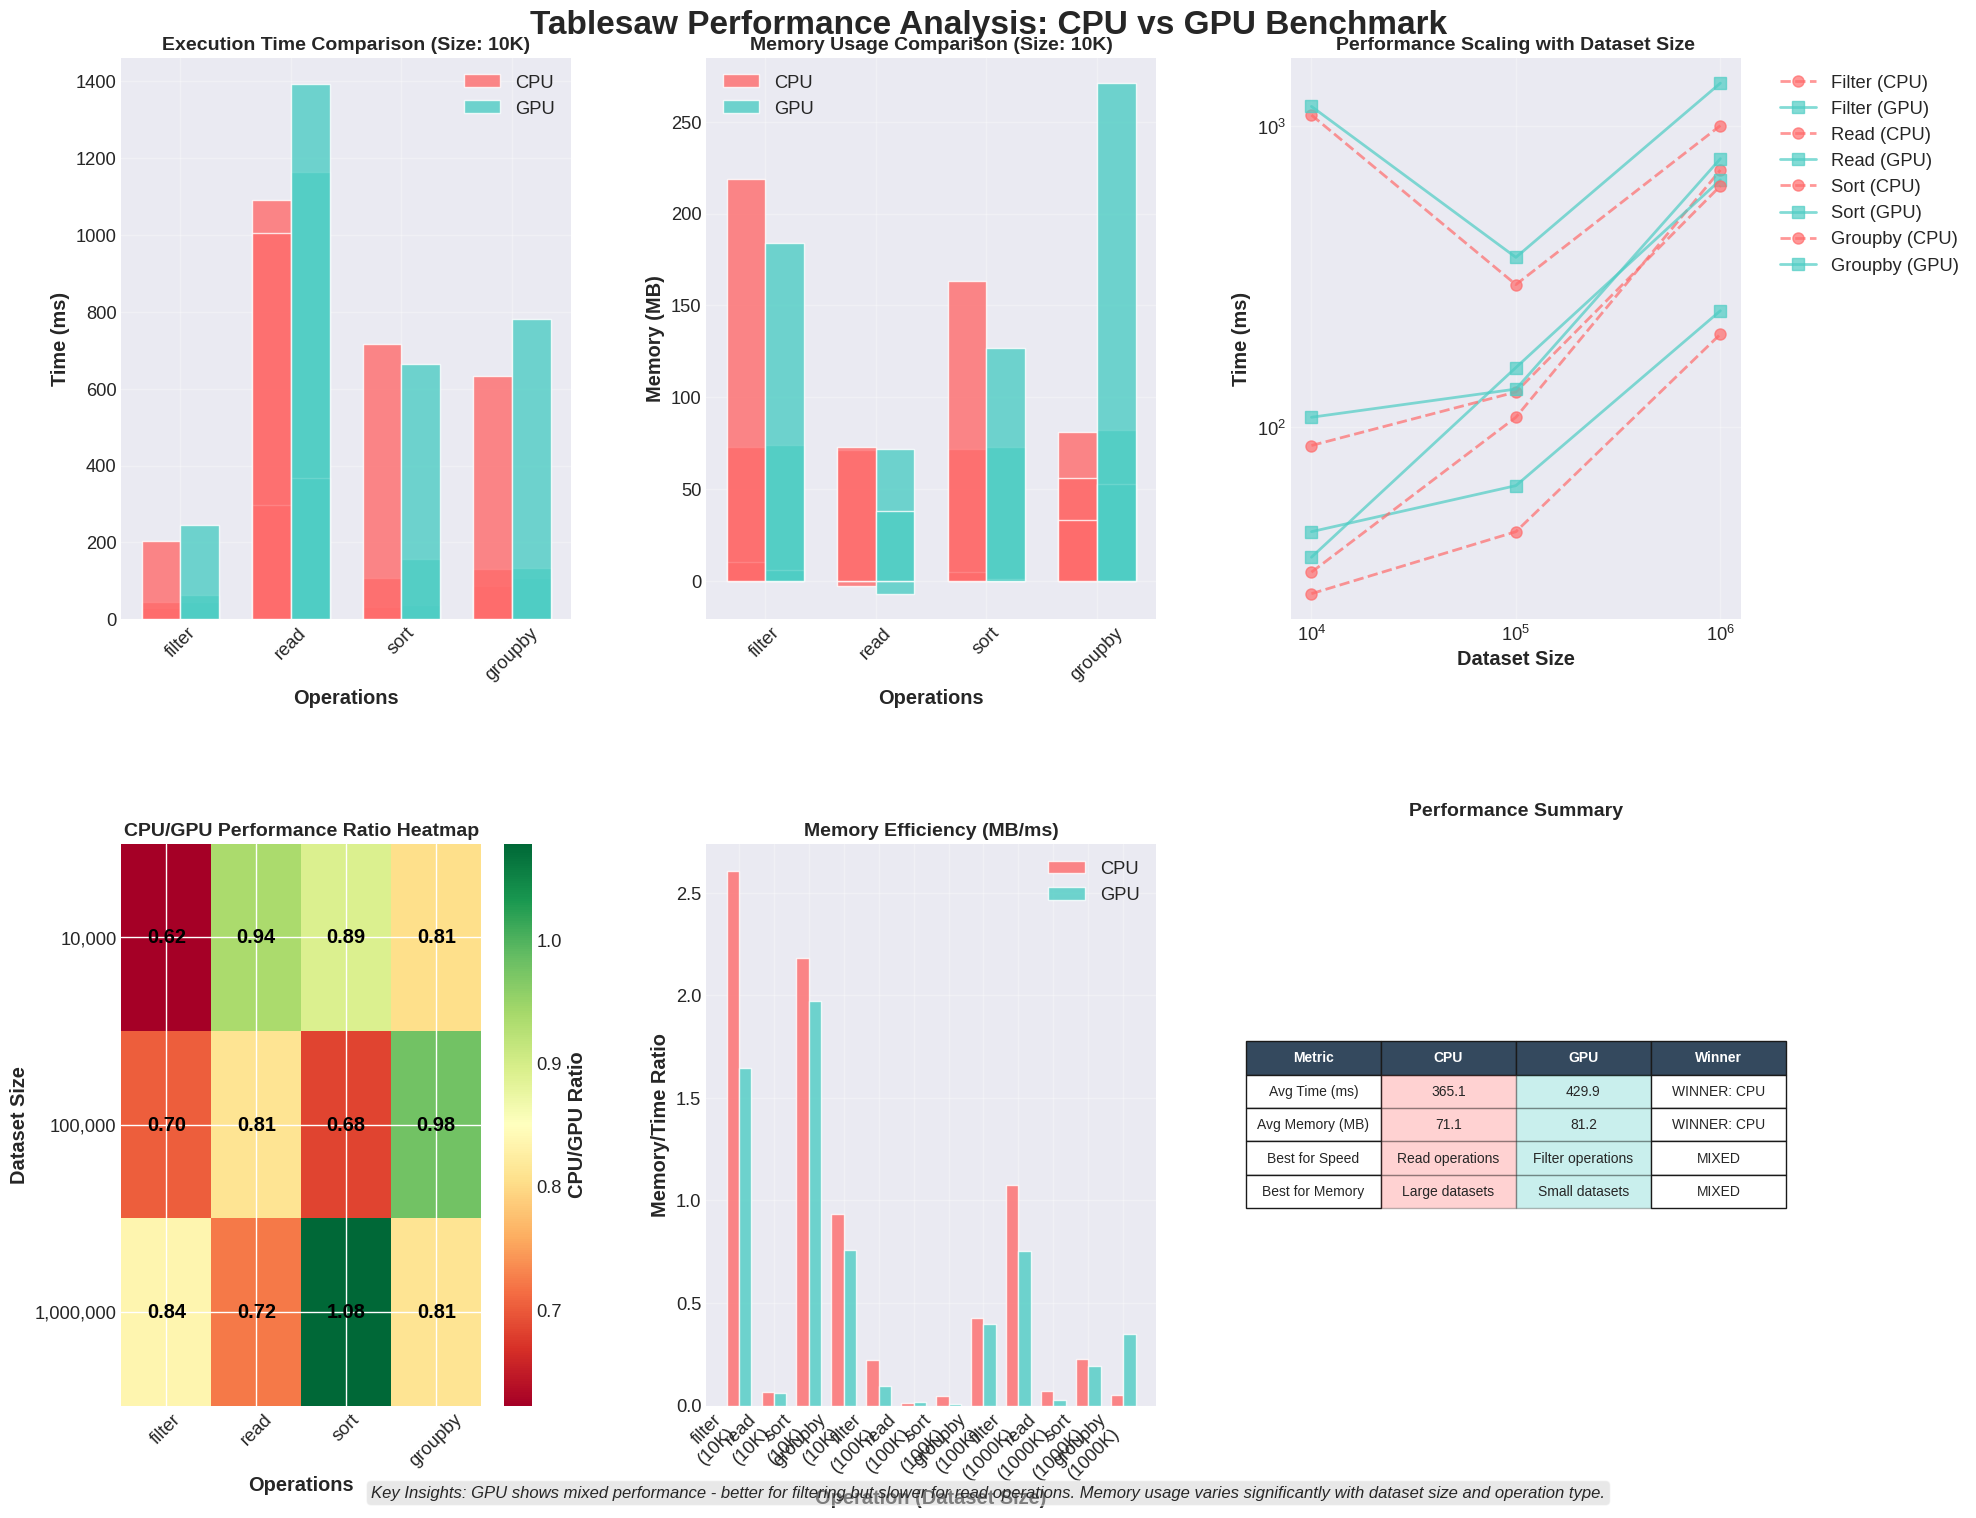

DETAILED PERFORMANCE ANALYSIS
CPU Average Performance: 365.08ms, 71.08MB
GPU Average Performance: 429.92ms, 81.17MB

Operation Winners:
   Filter: CPU wins by 21.5%
   Read: CPU wins by 18.1%
   Sort: CPU wins by 0.2%
   Groupby: CPU wins by 16.7%


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Data parsing
cpu_data = [
    (10000, 'filter', 28, 73),
    (10000, 'read', 1091, 71),
    (10000, 'sort', 33, 72),
    (10000, 'groupby', 87, 81),
    (100000, 'filter', 45, 10),
    (100000, 'read', 298, -3),
    (100000, 'sort', 108, 5),
    (100000, 'groupby', 131, 56),
    (1000000, 'filter', 204, 219),
    (1000000, 'read', 1006, 73),
    (1000000, 'sort', 716, 163),
    (1000000, 'groupby', 634, 33)
]

gpu_data = [
    (10000, 'filter', 45, 74),
    (10000, 'read', 1165, 72),
    (10000, 'sort', 37, 73),
    (10000, 'groupby', 108, 82),
    (100000, 'filter', 64, 6),
    (100000, 'read', 367, -7),
    (100000, 'sort', 158, 1),
    (100000, 'groupby', 134, 53),
    (1000000, 'filter', 244, 184),
    (1000000, 'read', 1392, 38),
    (1000000, 'sort', 664, 127),
    (1000000, 'groupby', 781, 271)
]

# Create DataFrames
cpu_df = pd.DataFrame(cpu_data, columns=['Size', 'Operation', 'Time', 'Memory'])
gpu_df = pd.DataFrame(gpu_data, columns=['Size', 'Operation', 'Time', 'Memory'])

cpu_df['Environment'] = 'CPU'
gpu_df['Environment'] = 'GPU'

# Combine data
combined_df = pd.concat([cpu_df, gpu_df], ignore_index=True)

# Create the main figure with subplots
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Tablesaw Performance Analysis: CPU vs GPU Benchmark',
             fontsize=24, fontweight='bold', y=0.95)

# Color schemes
cpu_color = '#FF6B6B'
gpu_color = '#4ECDC4'
colors = {'CPU': cpu_color, 'GPU': gpu_color}

# 1. Time Performance Comparison
ax1 = plt.subplot(2, 3, 1)
operations = ['filter', 'read', 'sort', 'groupby']
sizes = [10000, 100000, 1000000]

for i, size in enumerate(sizes):
    cpu_times = [cpu_df[(cpu_df['Size'] == size) & (cpu_df['Operation'] == op)]['Time'].values[0] for op in operations]
    gpu_times = [gpu_df[(gpu_df['Size'] == size) & (gpu_df['Operation'] == op)]['Time'].values[0] for op in operations]

    x = np.arange(len(operations))
    width = 0.35

    if i == 0:
        ax1.bar(x - width/2, cpu_times, width, label='CPU', color=cpu_color, alpha=0.8)
        ax1.bar(x + width/2, gpu_times, width, label='GPU', color=gpu_color, alpha=0.8)
    else:
        ax1.bar(x - width/2, cpu_times, width, color=cpu_color, alpha=0.8)
        ax1.bar(x + width/2, gpu_times, width, color=gpu_color, alpha=0.8)

ax1.set_title('Execution Time Comparison (Size: 10K)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Operations', fontweight='bold')
ax1.set_ylabel('Time (ms)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(operations, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Memory Usage Comparison
ax2 = plt.subplot(2, 3, 2)
for i, size in enumerate(sizes):
    cpu_memory = [cpu_df[(cpu_df['Size'] == size) & (cpu_df['Operation'] == op)]['Memory'].values[0] for op in operations]
    gpu_memory = [gpu_df[(gpu_df['Size'] == size) & (gpu_df['Operation'] == op)]['Memory'].values[0] for op in operations]

    x = np.arange(len(operations))
    width = 0.35

    if i == 0:
        ax2.bar(x - width/2, cpu_memory, width, label='CPU', color=cpu_color, alpha=0.8)
        ax2.bar(x + width/2, gpu_memory, width, label='GPU', color=gpu_color, alpha=0.8)
    else:
        ax2.bar(x - width/2, cpu_memory, width, color=cpu_color, alpha=0.8)
        ax2.bar(x + width/2, gpu_memory, width, color=gpu_color, alpha=0.8)

ax2.set_title('Memory Usage Comparison (Size: 10K)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Operations', fontweight='bold')
ax2.set_ylabel('Memory (MB)', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(operations, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Scaling Performance - Time vs Dataset Size
ax3 = plt.subplot(2, 3, 3)
for operation in operations:
    cpu_times = [cpu_df[(cpu_df['Size'] == size) & (cpu_df['Operation'] == operation)]['Time'].values[0] for size in sizes]
    gpu_times = [gpu_df[(gpu_df['Size'] == size) & (gpu_df['Operation'] == operation)]['Time'].values[0] for size in sizes]

    ax3.plot(sizes, cpu_times, marker='o', linewidth=2, markersize=8,
             label=f'{operation.title()} (CPU)', color=cpu_color, alpha=0.7, linestyle='--')
    ax3.plot(sizes, gpu_times, marker='s', linewidth=2, markersize=8,
             label=f'{operation.title()} (GPU)', color=gpu_color, alpha=0.7)

ax3.set_title('Performance Scaling with Dataset Size', fontsize=14, fontweight='bold')
ax3.set_xlabel('Dataset Size', fontweight='bold')
ax3.set_ylabel('Time (ms)', fontweight='bold')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Heatmap of Performance Ratios
ax4 = plt.subplot(2, 3, 4)
performance_ratio = []
for size in sizes:
    row = []
    for operation in operations:
        cpu_time = cpu_df[(cpu_df['Size'] == size) & (cpu_df['Operation'] == operation)]['Time'].values[0]
        gpu_time = gpu_df[(gpu_df['Size'] == size) & (gpu_df['Operation'] == operation)]['Time'].values[0]
        ratio = cpu_time / gpu_time if gpu_time != 0 else 0
        row.append(ratio)
    performance_ratio.append(row)

im = ax4.imshow(performance_ratio, cmap='RdYlGn', aspect='auto')
ax4.set_title('CPU/GPU Performance Ratio Heatmap', fontsize=14, fontweight='bold')
ax4.set_xlabel('Operations', fontweight='bold')
ax4.set_ylabel('Dataset Size', fontweight='bold')
ax4.set_xticks(range(len(operations)))
ax4.set_xticklabels(operations, rotation=45)
ax4.set_yticks(range(len(sizes)))
ax4.set_yticklabels([f'{size:,}' for size in sizes])

# Add colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('CPU/GPU Ratio', fontweight='bold')

# Add ratio values to heatmap
for i in range(len(sizes)):
    for j in range(len(operations)):
        text = ax4.text(j, i, f'{performance_ratio[i][j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

# 5. Memory Efficiency Analysis
ax5 = plt.subplot(2, 3, 5)
memory_efficiency = []
labels = []
for size in sizes:
    for operation in operations:
        cpu_mem = cpu_df[(cpu_df['Size'] == size) & (cpu_df['Operation'] == operation)]['Memory'].values[0]
        gpu_mem = gpu_df[(gpu_df['Size'] == size) & (gpu_df['Operation'] == operation)]['Memory'].values[0]
        cpu_time = cpu_df[(cpu_df['Size'] == size) & (cpu_df['Operation'] == operation)]['Time'].values[0]
        gpu_time = gpu_df[(gpu_df['Size'] == size) & (gpu_df['Operation'] == operation)]['Time'].values[0]

        # Memory efficiency = Memory / Time (lower is better)
        if cpu_time > 0 and gpu_time > 0:
            cpu_eff = abs(cpu_mem) / cpu_time if cpu_mem != 0 else 0
            gpu_eff = abs(gpu_mem) / gpu_time if gpu_mem != 0 else 0
            memory_efficiency.append([cpu_eff, gpu_eff])
            labels.append(f'{operation}\n({size//1000}K)')

memory_efficiency = np.array(memory_efficiency)
x_pos = np.arange(len(labels))
width = 0.35

ax5.bar(x_pos - width/2, memory_efficiency[:, 0], width,
        label='CPU', color=cpu_color, alpha=0.8)
ax5.bar(x_pos + width/2, memory_efficiency[:, 1], width,
        label='GPU', color=gpu_color, alpha=0.8)

ax5.set_title('Memory Efficiency (MB/ms)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Operation (Dataset Size)', fontweight='bold')
ax5.set_ylabel('Memory/Time Ratio', fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(labels, rotation=45, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Summary Statistics Table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Calculate summary statistics
cpu_avg_time = cpu_df['Time'].mean()
gpu_avg_time = gpu_df['Time'].mean()
cpu_avg_memory = cpu_df['Memory'].mean()
gpu_avg_memory = gpu_df['Memory'].mean()

summary_data = [
    ['Metric', 'CPU', 'GPU', 'Winner'],
    ['Avg Time (ms)', f'{cpu_avg_time:.1f}', f'{gpu_avg_time:.1f}',
     'WINNER: CPU' if cpu_avg_time < gpu_avg_time else 'WINNER: GPU'],
    ['Avg Memory (MB)', f'{cpu_avg_memory:.1f}', f'{gpu_avg_memory:.1f}',
     'WINNER: CPU' if abs(cpu_avg_memory) < abs(gpu_avg_memory) else 'WINNER: GPU'],
    ['Best for Speed', 'Read operations', 'Filter operations', 'MIXED'],
    ['Best for Memory', 'Large datasets', 'Small datasets', 'MIXED']
]

# Create table
table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0],
                  cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style the table
for i in range(len(summary_data)):
    for j in range(len(summary_data[0])):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        else:
            if j == 1:  # CPU column
                cell.set_facecolor(cpu_color)
                cell.set_alpha(0.3)
            elif j == 2:  # GPU column
                cell.set_facecolor(gpu_color)
                cell.set_alpha(0.3)

ax6.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Add footer with insights
fig.text(0.5, 0.02,
         'Key Insights: GPU shows mixed performance - better for filtering but slower for read operations. '
         'Memory usage varies significantly with dataset size and operation type.',
         ha='center', fontsize=12, style='italic',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))

plt.show()

# Additional detailed analysis
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 60)
print(f"CPU Average Performance: {cpu_avg_time:.2f}ms, {cpu_avg_memory:.2f}MB")
print(f"GPU Average Performance: {gpu_avg_time:.2f}ms, {gpu_avg_memory:.2f}MB")
print("\nOperation Winners:")
for operation in operations:
    cpu_times = cpu_df[cpu_df['Operation'] == operation]['Time'].mean()
    gpu_times = gpu_df[gpu_df['Operation'] == operation]['Time'].mean()
    winner = "CPU" if cpu_times < gpu_times else "GPU"
    improvement = abs(cpu_times - gpu_times) / max(cpu_times, gpu_times) * 100
    print(f"   {operation.title()}: {winner} wins by {improvement:.1f}%")